# **Introduction**:

Have you ever wondered how a computer or a machine can differentiate between a man and a woman or a flower and an animal? Well, it’s easy for us humans because we can understand the differences in their sizes and shapes and their particular properties, but a computer doesn’t understand or see things as we do. So, we have to train them.Here, in this notebook, I am going to work on Image Classification using the `CIFAR100` dataset using Deep Learning Algorithms. For this task, I will use transfer learning.

## **The CIFAR-100 dataset**:

The `CIFAR-100` dataset consists of 60000 32x32 color images in 100 classes, with 600 images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs). There are 50000 training images and 10000 test images.Here is the list of Superclass/classes in the ``CIFAR-100``:

In [ ]:
import pandas as pd
pd.read_html('https://www.cs.toronto.edu/~kriz/cifar.html', header=0)[2]

,Superclass,Classes
0,aquatic mammals,"beaver, dolphin, otter, seal, whale"
1,fish,"aquarium fish, flatfish, ray, shark, trout"
2,flowers,"orchids, poppies, roses, sunflowers, tulips"
3,food containers,"bottles, bowls, cans, cups, plates"
4,fruit and vegetables,"apples, mushrooms, oranges, pears, sweet peppers"
5,household electrical devices,"clock, computer keyboard, lamp, telephone, tel..."
6,household furniture,"bed, chair, couch, table, wardrobe"
7,insects,"bee, beetle, butterfly, caterpillar, cockroach"
8,large carnivores,"bear, leopard, lion, tiger, wolf"
9,large man-made outdoor things,"bridge, castle, house, road, skyscraper"


## **Our Task**:

### **Task-1**:
We will download the `CIFAR-100` dataset for 'coarse' label (20 superclasses)

### **Task-2**:
We will apply `transfer learning` to do model training.

### **Task-3**:
We will do the performance evaluation of the trained model and we will also discuss about possible improvements.

### **Task-4**:
1) I will try to explain the regularization techniques i used in this project.I will also try to explain briefly why i chose `EfficientNet` as a  convolutional neural network architecture for this project.

## **Task-1**

In [ ]:
#########################################  Library import  ##############################################################

import os
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import collections
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100
import cv2
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import efficientnet.tfkeras as efn 

###########################################(1)Download the cifra-100 dataset for 'coarse' label (20 superclasses) ##############

# Load CIFAR-100 dataset & check data dimension
print('== Reading raw dataset ==')
(X, y), (X_test, y_test) = cifar100.load_data(label_mode='coarse')
print("Downloaded the cifar-100 dataset for 'coarse' label (20 superclasses).")
print("Training dataset consists of {}  {}*{} colour images.".format(X.shape[0],X.shape[1],X.shape[2]))
print("Test dataset consists of {}  {}*{} colour images.".format(X_test.shape[0],X_test.shape[1],X_test.shape[2]))

############################################### Parameter declaration #######################################################

# data
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)


# optimizers
lr = 1e-3

# training
epochs = 25
batch_size = 8

# callback functions
es_patience = 10
rlrop_patience = 5
decay_rate = 0.5

####################################### Function & class declaration ################################################################

def volume_calculation(target_data):
    vol_per_sup_cls=dict(collections.Counter(target_data[:,0]))
    sorted_vol_per_sup_cls = collections.OrderedDict(sorted(vol_per_sup_cls.items()))
    return list(sorted_vol_per_sup_cls.values())



def df_prep(web_link,table_no):
    df = pd.read_html(web_link, header=0)[table_no]
    del df['Classes']
    df['Train_volume']=volume_calculation(y)
    df['Test_volume']=volume_calculation(y_test)
    return df


def figure_plot(no_of_row,no_of_col,Width, height):
    plt.figure(figsize=(Width, height))
    superclass_list = list(df_prep("https://www.cs.toronto.edu/~kriz/cifar.html",2)["Superclass"])
    superclass_label_list = np.unique(y)
    for index in range(len(superclass_label_list)):
        image_per_superclass = X[y.reshape(-1) == superclass_label_list[index]][:1]
        plt.subplot(no_of_row,no_of_col,1+index)
        plt.title("%s" % (superclass_list[superclass_label_list[index]].capitalize()), y = 1)
        plt.axis('off')
        plt.imshow(image_per_superclass[0],cmap='gray')
        
        
# The bicubic method is a good choice interpolation when upscaling images and it can be implemented by cv2.INTER_CUBIC

def np_resize(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)


coarse_label_list =  list(df_prep("https://www.cs.toronto.edu/~kriz/cifar.html",2)["Superclass"])
n_classes = len(coarse_label_list)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images , labels = None, mode = 'fit', batch_size = batch_size,
                 dim = (height, width), channels = channels, n_classes = n_classes,
                 shuffle = True, augment = False):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # For generating mini-batch of X
        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            # Generate a preprocessed image
            img = self.images[ID]
            img = img.astype(np.float32) / 255.
            img = np_resize(img, self.dim)
            X[i] = img
            
        # For generating mini-batch of y
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            y = to_categorical(y, n_classes) 
            if self.augment == True:
                X = self.__augment_batch(X)                
            
            return X,y
        
        elif self.mode == 'predict':
            return X       
        
        else:
            raise AttributeError('The mode parameters should be set to "fit" or "predict"')
            
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                    albu.VerticalFlip(p = 0.5),
                                    albu.GridDistortion(p = 0.2),
                                    albu.ElasticTransform(p = 0.2)])
        
        return composition(image = img)['image']
        
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
            
        return img_batch
    

== Reading raw dataset ==
Downloaded the cifar-100 dataset for 'coarse' label (20 superclasses).
Training dataset consists of 50000  32*32 colour images.
Test dataset consists of 10000  32*32 colour images.


In [ ]:
###########################################################  Dataframe preparation  ####################################################################

df_prep("https://www.cs.toronto.edu/~kriz/cifar.html",2)

,Superclass,Train_volume,Test_volume
0,aquatic mammals,2500,500
1,fish,2500,500
2,flowers,2500,500
3,food containers,2500,500
4,fruit and vegetables,2500,500
5,household electrical devices,2500,500
6,household furniture,2500,500
7,insects,2500,500
8,large carnivores,2500,500
9,large man-made outdoor things,2500,500


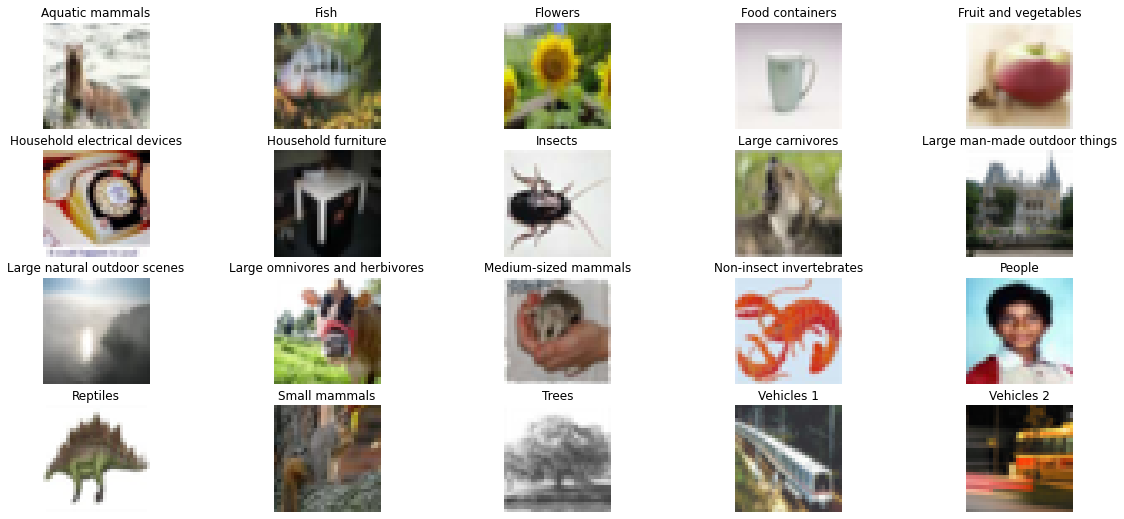

In [ ]:
################# Took one image from each class (20 superclasses) and plotted them side-by-side in (4,5)-shape      ##################

figure_plot(4,5,20, 9)

## **Task-2**:


Transfer learning delivers better results in a shorter amount of time.Due to that i have decided to use transfer learning for
this task.

In [ ]:
################################################ training data split ########################################################

# Spliting the training data into a training data and a validation data
st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)
for train_index, val_index in st.split(X, y):
    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
    
print("The number of training data : ", X_train.shape[0])
print("The number of validation data : ", X_val.shape[0])

del X, y


The number of training data :  40000
The number of validation data :  10000


The paper `EfficientNet` says balancing model's depth, model's width and resolution of input images is important for model scaling.So original images should be resized to the specified size, which is (224, 224) in the case of `EfficientNetB0`. 
Image interpolation algorithms directly affect the quality of image magnification.Out of various interpolation techniques we need to be careful while selecting as the resolution of this dataset is lower.The bicubic method is a good choice of interpolation when upscaling images.Images resampled with bicubic interpolation are smoother and have fewer interpolation artifacts.It can be implemented by `cv2.INTER_CUBIC`.To do this, I used a custom `DataGenerator` that contains resizing a image.

In [ ]:
# Data generation
train_generator = DataGenerator(X_train, y_train, augment = True)
valid_generator = DataGenerator(X_val, y_val, augment = False)

In [ ]:
# Model preparation
efnb0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False, classes = n_classes, input_shape = input_shape)
model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation = 'softmax'))
model.summary()

2022-01-22 05:39:54.670143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 05:39:54.808485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 05:39:54.809214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 05:39:54.810623: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

16818176/16804768 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                25620     
Total params: 4,075,184
Trainable params: 4,033,168
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
# Hyperparameter declaration
efnb0.trainable = False
sgd = SGD(lr = lr, momentum = 0.9, nesterov = True)
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-6, verbose = 1)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])
hist = model.fit_generator(train_generator,validation_data = valid_generator, 
                           epochs = epochs, verbose = 1, callbacks = [es, rlrop])

# Best weight saving
model.save_weights("best_weight.h5")

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-01-22 05:40:00.859286: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-01-22 05:40:08.670272: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5000/5000 [==============================] - 690s 135ms/step - loss: 1.5579 - acc: 0.5165 - val_loss: 0.6600 - val_acc: 0.7886
Epoch 2/25
5000/5000 [==============================] - 688s 138ms/step - loss: 1.0424 - acc: 0.6701 - val_loss: 0.5223 - val_acc: 0.8318
Epoch 3/25
5000/5000 [==============================] - 676s 135ms/step - loss: 0.8844 - acc: 0.7161 - val_loss: 0.4783 - val_acc: 0.8485
Epoch 4/25
5000/5000 [==============================] - 687s 137ms/step - loss: 0.7915 - acc: 0.7483 - val_loss: 0.4605 - val_acc: 0.8571
Epoch 5/25
5000/5000 [==============================] - 701s 140ms/step - loss: 0.7179 - acc: 0.7696 - val_loss: 0.4442 - val_acc: 0.8651
Epoch 6/25
5000/5000 [==============================] - 677s 135ms/step - loss: 0.6573 - acc: 0.7898 - val_loss: 0.4211 - val_acc: 0.8733
Epoch 7/25
5000/5000 [==============================] - 685s 137ms/step - loss: 0.6098 - acc: 0.8047 - val_loss: 0.4313 - val_acc: 0.8728
Epoch 8/25
5000/5000 [=======================

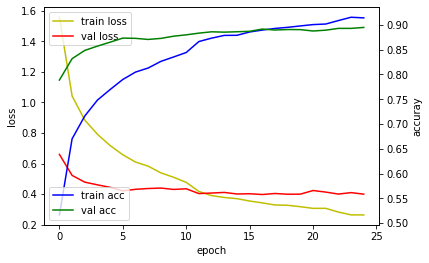

In [ ]:
#################################################### Learning curve #######################################################################

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# Inference

In [ ]:
# Validation data
print("The Accuracy on the validation data : {:.2f}%".format(100 * model.evaluate_generator(valid_generator, verbose = 1)[-1]))

   6/1250 [..............................] - ETA: 28s - loss: 0.4159 - acc: 0.9167

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1250/1250 [==============================] - 22s 17ms/step - loss: 0.3997 - acc: 0.8948
The Accuracy on the validation data : 89.48%


In [ ]:
# Test data 
test_generator = DataGenerator(X_test, mode = 'predict', augment = False, shuffle = False)
y_pred = model.predict_generator(test_generator,verbose = 1)
y_pred = np.argmax(y_pred, axis = 1)

print("The accuracy on the testing data : {:.2f}%".format(100 * accuracy_score(y_test, y_pred)))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1250/1250 [==============================] - 19s 15ms/step
The accuracy on the testing data : 89.81%


## **Task-3**:

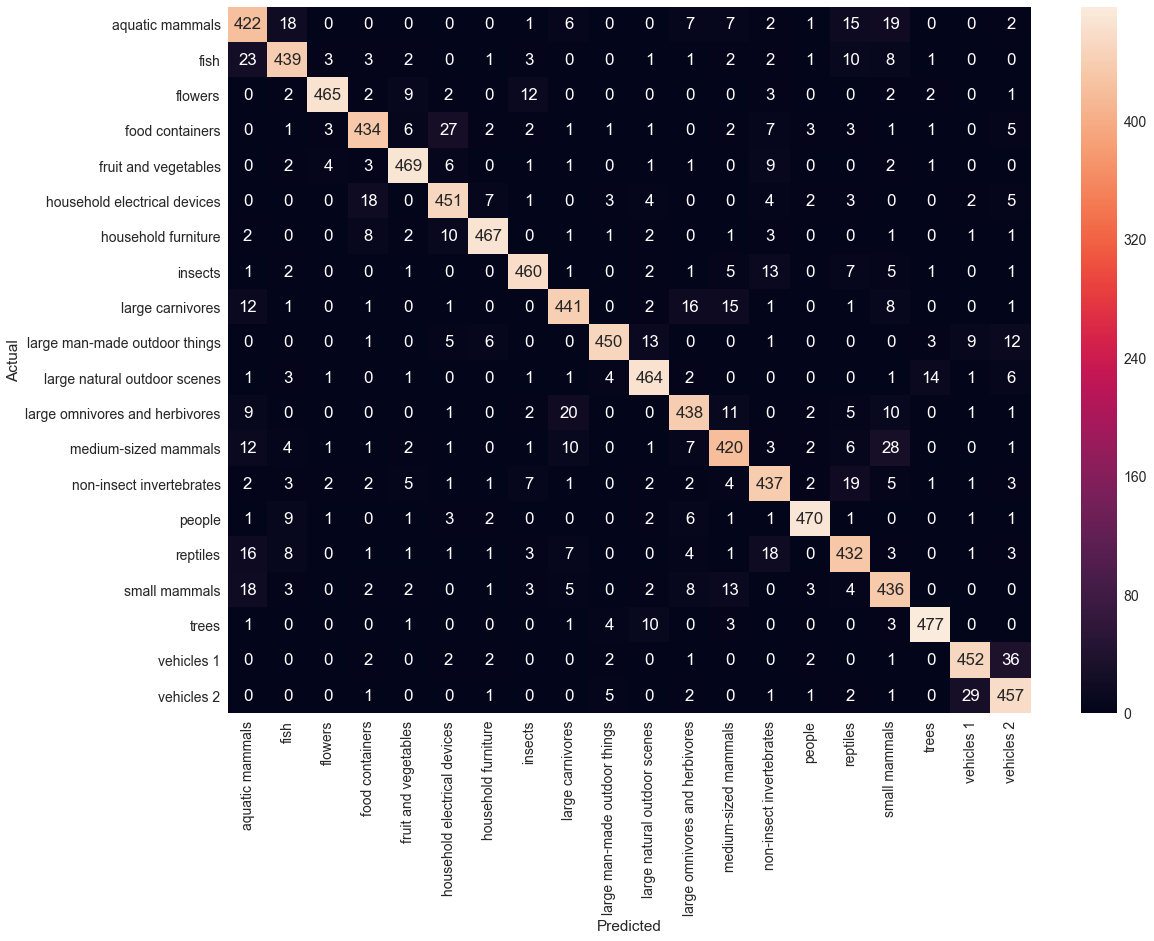

In [ ]:
###########################################  Performance evaluation #########################################################
## Confusion matrix 
conf_mat = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(18,13))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=coarse_label_list, yticklabels=coarse_label_list, )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names =coarse_label_list))

                                precision    recall  f1-score   support

               aquatic mammals       0.81      0.84      0.83       500
                          fish       0.89      0.88      0.88       500
                       flowers       0.97      0.93      0.95       500
               food containers       0.91      0.87      0.89       500
          fruit and vegetables       0.93      0.94      0.94       500
  household electrical devices       0.88      0.90      0.89       500
           household furniture       0.95      0.93      0.94       500
                       insects       0.93      0.92      0.92       500
              large carnivores       0.89      0.88      0.89       500
 large man-made outdoor things       0.96      0.90      0.93       500
  large natural outdoor scenes       0.92      0.93      0.92       500
large omnivores and herbivores       0.88      0.88      0.88       500
          medium-sized mammals       0.87      0.84      0.85  

Performance indicators are very useful when the aim is to evaluate and compare different classification models or machine-learning techniques.Many metrics(e.g. Precision, Recall, F1, Confusion Matrix) come in handy to test the ability of a multi-class classifier. It is important that this choice is backed by analytical reasoning.However, I will first look at the test dataset. The test dataset is a balanced dataset. Due to that, I will check the accuracy first.The accuracy of the model based on the test data is `89.81%` which is pretty good. The f1 score for each class is above `80%`.Most of them reached close to `90%` which is impressive.For the class named "Tree" & "People" number of true positives is higher compared to other classes. But if we look at the confusion matrix then from that we can observe that for different types of mammals our model did not perform well compared to other classes. It seems it was tough to distinguish between aquatic mammals, medium-sized mammals, and small mammals properly.If we consider vehicles 1 & vehicle 2 as part of vehicles then its also tough to differentiate properly as 36 vehicles 1 were wrongly classified as vehicles 2 & 29 Vehicle 2 was wrongly classified as vehicle 1. 


### **Possible improvements:**

Still, there is room for improvement though overall performance is nice. If we need to think about improvement then we need to think about fine-tuning the model.Any Deep Learning model has a set of parameters and hyper-parameters. Hyper-parameters are set by us.Because of the flexibility deep learning provides in model creation, we have to pick these hyper-parameters carefully to achieve the best performance which is part of fine-tuning.Finding the best hyper-parameters for the model is hard. There are several hyper-parameter optimization libraries that can be used to improve the performance of the model.

## Task-4:


## **Regularization techniques I used**:


### **i) Dropout**
We use regularization to fix overfitting in our model. Overfitting means high variance.Variance is the amount that the prediction will change if you change the training data.A lot of flexibility in the model causes high variance.The more parameters that we have in our model the more is the flexibility.It means we can tweak more things in our model which is more likely that our model will have high variance.Here comes the concept of regularization which helps to limit this flexibility that the model has in hopes to avoid overfitting.This could be done in a bunch of different ways.There are not many strong, well-documented principles to help us decide between types of regularization. A workable approach can be based on experience, and following literature and other people's results to see what gave good results in different problem domains. Bearing this in mind, dropout has proved very successful for a broad range of problems, and we can probably consider it as a good first choice almost regardless of what i am attempting.

Dropout is created as a regularization technique, that we can use to reduce the model capacity so that our model can achieve lower generalization error.This is an approach to regularization in neural networks which helps reducing interdependent learning amongst the neurons.It refers to ignoring units (i.e. neurons) during the training phase of certain set of neurons which is chosen at random.More technically, at training stage, individual nodes are either dropped out of the net with probability 1-p or kept with probability p, so that a reduced network is left; incoming and outgoing edges to a dropped-out node are also removed.This offers a very computationally cheap and remarkably effective regularization method to reduce overfitting and improve generalization error in deep neural networks of all kinds.A small dropout value of 0.2–0.5 is recommended to start with.During training i have used dropout rate =0.2 as fraction of the input units to drop.Because of time contrains i didnot got enough chance to conduct trial & error process to find the best dropout rate.
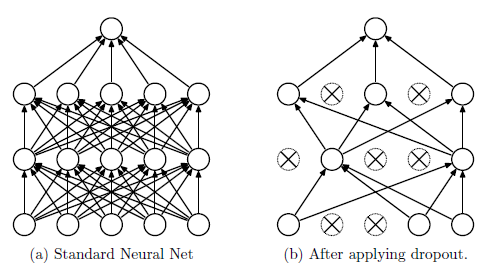

### **ii) Early stopping**

Early Stopping is a regularization technique for deep neural networks that stops training when parameter updates no longer begin to yield improves on a validation set. In essence, we store and update the current best parameters during training, and when parameter updates no longer yield an improvement (after a set number of iterations) we stop training and use the last best parameters. It works as a regularizer by restricting the optimization procedure to a smaller volume of parameter space.
Early Stopping, does not only protect against overfitting but needs considerably less number of Epoch to train which inspired me to use it during training.It is perhaps the simplest regularization strategy.
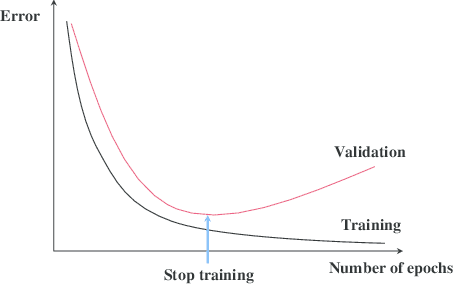

### **iii) Data augmentation** 

A convolutional neural network that can robustly classify objects even if its placed in different orientations is said to have the property called invariance.This essentially is the premise of data augmentation. Using this we can reduce overfitting on models, where we increase the amount of training data using information only in our training data.Explicit data augmentation directly transforms the existing data to obtain new samples, via techniques such as rotation and mirroring in the case of image data.By performing augmentation, can prevent our neural network from learning irrelevant patterns, essentially boosting overall performance which inspired me to use that during training.
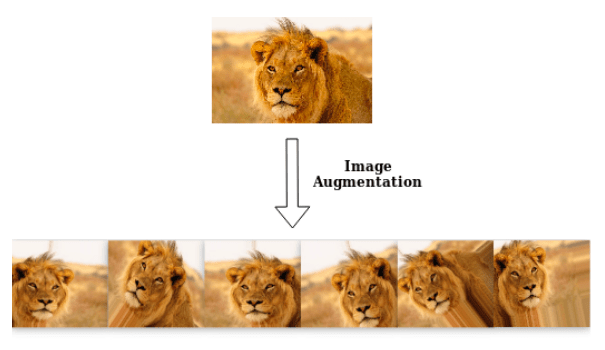


## **Why EfficientNet?**:

Convolutional neural networks (CNNs) needs to be scaled up in order to achieve better accuracy.The conventional practice for model scaling is to arbitrarily increase the CNN depth or width, or to use larger input image resolution for training and evaluation. While these methods do improve accuracy, they usually require tedious manual tuning, and still often yield suboptimal performance. EfficientNet, introduced a novel model scaling method that uses a simple yet highly effective compound coefficient to scale up CNNs in a more structured manner.For EfficientNet, its main building block is mobile inverted bottleneck MBConv, which was first introduced in MobileNetV2. By using shortcuts directly between the bottlenecks which connects a much fewer number of channels compared to expansion layers, combined with depthwise separable convolution which effectively reduces computation by almost a factor of k2, compared to traditional layers. Where k stands for the kernel size, specifying the height and width of the 2D convolution window.Inside EfficientNet squeeze-and-excitation(SE)were added as an optimization, which contributes to further performance improvements.Though EfficientNets performed well on ImageNet, to be most useful, they also havethe ability to transfer well to other datasets.This inspired me to try EfficientNet for this project.By using efficient it was possible to improve accuracy without significantly increasing the number of parameters.To pick from various variants of EfficientNet i did my research & was convinced to use EfficientNetV2 for this task.I was dependent upon free gpu services as i dont have personal GPU.The free service i used got a time limit of 9 hours for each project.Unfortunately because of that it was not possible to finish the training completely using GPU.




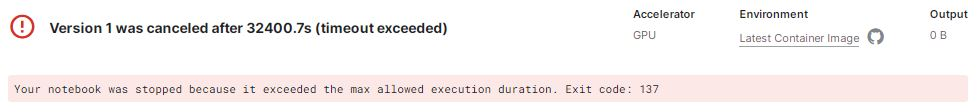



Next i decided to pick the baseline model called EfficientNetB0.It was also my keen interest to try  EfficientNetB7.But because of lacking of GPU(free hours) i couldnot.   

## **References**:
    
1. https://en.wikipedia.org/wiki/Bicubic_interpolation
2. Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever, Ruslan Salakhutdinov, "Dropout: A Simple Way to Prevent Neural Networks from Overfitting", Journal of Machine Learning Research, 2014.
3. https://en.wikipedia.org/wiki/Data_augmentation
4. http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf
5. Mingxing Tan, Quoc V. Le,  "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks",International Conference on Machine Learning, 2019
6. Mingxing Tan, Quoc V. Le, "EfficientNetV2: Smaller Models and Faster Training", International Conference on Machine Learning, 2021